<a href="https://colab.research.google.com/github/madelinechertkow/mchertkow225a/blob/main/Code/Copy_of_Chertkow_bms225a_ds_workshop4_student_notebook_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [ ]:
# install scanpy with additional dependences
# leiden for clustering, harmony for batch correction and skmisc which is needed for HVG selection
!pip install --quiet 'scanpy[leiden,harmony,skmisc]'

In [ ]:
# @title This re-runs workshop3 code and saves the corresponding data in the BMS225A folder
################# THIS IS NOT PART OF THE WORKFLOW ##################
import os
import warnings
warnings.filterwarnings("ignore")

if not os.path.exists('/content/blood_RNA.h5ad'):
  # downloading the data from the paper takes ~1min
  !wget -O blood_RNA.h5ad --header="User-Agent: Mozilla/5.0" "https://figshare.com/ndownloader/files/38849385?private_link=8aaa376913da23ae0def" > /dev/null 2>&1


if not os.path.exists('./BMS225A/Workshop3/processed_data/blood_RNA_BMS225a_single_batch.h5ad'):

  !mkdir -p ./BMS225A/Workshop3/processed_data
  !mkdir -p ./BMS225A/Workshop3/raw_data
  # -- create the raw data by removing all processed data information from the author's file
  import scanpy as sc
  # load the single cell RNA seq dataset from the h5ad file
  adata_processed = sc.read_h5ad('blood_RNA.h5ad') # AnnData object
  X_raw_counts = adata_processed.layers['counts']
  # the var dataframe
  raw_var_df = adata_processed.raw.var.copy()
  for i in raw_var_df.columns:
    del raw_var_df[i]
  raw_var_df['gene_name'] = raw_var_df.index
  # the obs dataframe
  raw_obs_df = adata_processed.obs[['LIBRARY',	'CoLabs_patient',	'condition']]
  raw_obs_df.columns = ['LIBRARY_ID', 'patient_id', 'condition']
  # create the anndata object
  adata = sc.AnnData(X = X_raw_counts, var=raw_var_df, obs=raw_obs_df)
  adata.write_h5ad('./BMS225A/Workshop3/raw_data/blood_RNA_raw_counts.h5ad')
  adata=adata[ adata.obs['LIBRARY_ID'] == 'XAUT1-POOL-SCG12']
  adata.write_h5ad('./BMS225A/Workshop3/raw_data/blood_RNA_raw_counts_SCG12.h5ad')
  del adata_processed # delete the processed data

  ################################### Workshop 3 ########################################################
  # adata = sc.read_h5ad('./BMS225A/Workshop3/raw_data/blood_RNA_raw_counts_SCG12.h5ad') # load the AnnData object from the h5ad file
  # QC and doublet detection
  adata.var["mt"] = adata.var_names.str.startswith("MT-") # mitochondrial genes, "MT-" for human, "Mt-" for mouse
  sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=True, percent_top = None) # calculate QC metrics
  sc.pp.filter_genes(adata,min_cells=5) #filter genes
  adata = adata[ adata.obs['log1p_total_counts']> 6.5 ] # filter cells based on counts
  adata = adata[ adata.obs['pct_counts_mt']< 12.5 ] # filter cells based on mito percentage
  sc.pp.scrublet(adata) # doublet detection with scrublet
  adata = adata[ adata.obs['predicted_doublet'] == False ] # filter out detected doublets

  # normalization and log-transformation
  adata.layers["counts"] = adata.X.copy() # saving count data to a new layer, before we proceed with normalization
  sc.pp.normalize_total(adata,target_sum=10000) # Normalizing to 10K total counts (CP10k)
  sc.pp.log1p(adata) # Logarithmize the data
  adata.layers['log1p'] = adata.X.copy() # save the log1p normalized counts to a new layer

  # highly variable gene selection
  sc.pp.highly_variable_genes(adata, n_top_genes = 2000, flavor='seurat_v3', layer='counts')

  # dimensionality reduction (PCA)
  sc.pp.scale(adata,zero_center=False) # scale each gene to unit variance (for pca only)
  sc.tl.pca(adata, n_comps=50) # specify number of PCs (default is 50)

  # knn graph, umap and leiden
  sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=15, random_state=42)
  sc.tl.umap(adata, min_dist=0.5, spread=1.0)
  sc.tl.leiden(adata, resolution=0.1,key_added='leiden')
  # annotate the clusters (code from workshop 3)
  clusters_to_labels = {
      '0':'T cells',
      '1':'Myeloid',
      '2':'NK cells',
      '3':'B cells'
  }
  # use the above dict to create a new column in obs with cells labels (we call it celltype here)
  adata.obs['celltype'] = adata.obs['leiden'].map(clusters_to_labels)
  !rm blood_RNA.h5ad
  adata.write_h5ad('./BMS225A/Workshop3/processed_data/blood_RNA_BMS225a_single_batch.h5ad')



# Workshop 4

In [ ]:
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
### Settings ###

# (optional) Show more columns in output
pd.set_option('display.max_columns', 50)

# (optional) Set parameters for the figures // sc.settings.set_figure_params?
sc.settings.set_figure_params(dpi=80,fontsize=16, facecolor="white",figsize=(8,6),color_map='viridis')

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False # turn off grids

# (optional) Suppress all warnings -- not recommended when working on your research projects!
import warnings
warnings.filterwarnings("ignore")

# print out the package versions
print('scanpy version:', sc.__version__)

# PBMC scanpy plotting tutorial
See also: https://scanpy.readthedocs.io/en/stable/tutorials/plotting/core.html

We will be using a PBMC (Peripheral Blood Mononuclear Cells) dataset from Scanpy for visualization and differential expression analysis.
This section loads the reduced PBMC dataset and prepares it for further analysis.


In [ ]:
# @title Load tutorial pbmc data
pbmc = sc.datasets.pbmc68k_reduced().raw.to_adata()
pbmc.layers['log1p'] = pbmc.X

# compute clusters using the leiden method and store the results with the name `clusters`
sc.tl.leiden(
    pbmc,
    key_added="clusters",
    resolution=0.5,
    n_iterations=2,
    flavor="igraph",
    directed=False,
)

## annotate
# create a dictionary to map cluster to annotation label
cluster2annotation = {
    "0": "Monocytes",
    "1": "NK",
    "2": "T-cell",
    "3": "Dendritic",
    "4": "Dendritic",
    "5": "Plasma",
    "6": "B-cell",
    "7": "Dendritic",
    "8": "Other",
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
pbmc.obs["cell type"] = pbmc.obs["clusters"].map(cluster2annotation).astype("category")

In [ ]:
# We will work with this dataset in this section.
# Preview the pbmc dataset with the annotations
pbmc

## Differential expression

We will now perform differential expression analysis using the Wilcoxon rank-sum test.
We specify the 'cell type' column for groupings and 'log1p' for the expression values.

In [ ]:
# Perform differential expression analysis
sc.tl.rank_genes_groups(pbmc,
                        groupby='cell type',
                        method='wilcoxon', # default is t-test, other tests also available
                        layer='log1p'
                        )

## DE plots

### logFC with dot plot
A dot plot visualization to see the log fold changes for the top differentially expressed genes.


In [ ]:
# Generate a dot plot for the top 6 genes (log fold change)
# we can change the colorbar range by setting the vmin, vmax parameters
# set the colormap with cmap, and filter genes with the min_logfoldchange parameter
sc.pl.rank_genes_groups_dotplot(pbmc,
                                n_genes=6,
                                values_to_plot='logfoldchanges',
                                dot_max=0.7
)

In [ ]:
#Dot plot for specific cell types (NK, Monocytes, B-cells)
sc.pl.rank_genes_groups_dotplot(pbmc,
                                n_genes=6,
                                min_logfoldchange=3,
                                values_to_plot='logfoldchanges',
                                vmax=5,
                                vmin=-5,
                                cmap='bwr',
                                dot_max=0.7,

                                groups=['NK','Monocytes','B-cell'],
)

### DE matrix plot

A matrix plot to visualize the expression of the top differentially expressed genes.
This plot shows log1p transformed expression values.

In [ ]:
# Generate a matrix plot of top 6 genes
sc.pl.rank_genes_groups_matrixplot(pbmc,
                                   n_genes=6,
                                   min_logfoldchange=3,

                                   layer="log1p", # here we are going to plot log1p expression
)

In [ ]:
# matrixplot with scaled expression per gene (values from 0 to 1 for each column)
sc.pl.rank_genes_groups_matrixplot(pbmc,
                                   n_genes=6,
                                   min_logfoldchange=3,
                                   layer="log1p",

                                   standard_scale='var', #normalize 0 to 1
                                   colorbar_title="max-scaled \n expression",
)

In [ ]:
# matrixplot with scaled expression per gene (zero mean and unit variance, z-score)

# 1. scale and store results in layer (z-score). Need to do this only once / results will be stored in a new layer
pbmc.layers["scaled"] = sc.pp.scale(pbmc, copy=True).X

In [ ]:
# 2. matrixplot with z-scores
sc.pl.rank_genes_groups_matrixplot(pbmc,
                                   n_genes=6,
                                   min_logfoldchange=3,

                                   vmax=3,
                                   vmin=-3,
                                   cmap='bwr',
                                   layer="scaled",
                                   colorbar_title="mean z-score",
)

### DE violin plot

A violin plot for the top DE genes showing their expression across cell types. The plot uses log1p transformed expression values and colors the violins according to the median expression.


In [ ]:
# Generate violin plot for top 10 genes
sc.pl.rank_genes_groups_stacked_violin(pbmc,
                                       n_genes=10,
                                       min_logfoldchange=3,

                                       dendrogram=False,
                                       cmap="viridis_r",
                                       layer="log1p",
                                       colorbar_title="median \n expression",
                                       figsize=(20,3)
                                       )

### Heatmap (all cells)

A heatmap for visualizing gene expression levels of top differentially expressed genes across all cells.


In [ ]:
sc.pl.rank_genes_groups_heatmap(
    pbmc,
    n_genes=6,
    min_logfoldchange=3,

    layer="log1p",
    # standard_scale='var',
    figsize=(14, 7),
)

In [ ]:
# (optional) swap the axes, include more genes, hide their names, and plot z-scores
sc.pl.rank_genes_groups_heatmap(
    pbmc,
    n_genes=15,
    min_logfoldchange=3,

    swap_axes=True,
    show_gene_labels=False,
    vmin=-3,
    vmax=3,
    cmap="bwr",
    layer="scaled",
)

### Tracksplot (all cells)

In [ ]:
sc.pl.rank_genes_groups_tracksplot(pbmc,
                                   n_genes=3,
                                   min_logfoldchange=3,

                                   layer="log1p",
                                   figsize=(15, 10),
)

## Correlation matrix

In [ ]:
# Generate a correlation matrix of expression values for cell types
sc.pl.correlation_matrix(pbmc,
                         groupby='cell type',
                         cmap='coolwarm',
                         figsize=(5, 3.5),
)

## Gene expression plots

### umap plot

In [ ]:
sc.pl.umap(pbmc,
           color='cell type')

In [ ]:
# UMAP plot highlighting expression of gene CD79A
sc.pl.umap(pbmc,
           color='CD79A',
          #  frameon=False,
           vmax="p99",
           layer='log1p')

In [ ]:
# Multiple UMAP plots for several genes and cell types
color_vars = ['CD79A', 'MS4A1', 'CD3D', 'GNLY', 'CST3', 'cell type']

sc.set_figure_params(figsize=(3,3))

sc.pl.umap(pbmc, color=color_vars, s=50, frameon=False, ncols=3, vmax="p99",layer='log1p',)

### dot plot
Dot plot for various genes across cell types.

In [ ]:
sc.pl.dotplot(pbmc,
              var_names = ["MS4A1", "CD3D",'CST3','FTL','CD74','S100A4'], # arbitrary list of genes (will trhow error if genes are not in adata.var_names)
              groupby = "cell type",
              dendrogram=True,
              layer='log1p',
              dot_max=0.7,
              figsize=(6,3),
              )

In [ ]:
# Dot plot with scaled expression values (z-score)
sc.pl.dotplot(pbmc,
              var_names = ["MS4A1", "CD3D",'CST3','FTL','CD74','S100A4'],
              groupby = "cell type",
              dendrogram=True,
              dot_max=0.7,
              figsize=(6,3),

              layer='scaled',
              vmin=-2,
              vmax=2,
              cmap='bwr',
              colorbar_title="mean z-score",
              )

### violin plot

In [ ]:
# Violin plot of selected genes across cell types, with both log1p and scaled values.

sc.set_figure_params(figsize=(4,3))
sc.pl.violin(pbmc,
             keys = ["MS4A1",'FTL','CD74','S100A4'],
             groupby = "cell type",
             rotation=90,
             layer='log1p',
             # stripplot=False,  # remove the internal dots
             # inner="box",  # adds a boxplot inside violins
             )

In [ ]:
# Violin plot with scaled expression instead of log1p.
sc.pl.violin(pbmc,
             keys = ["MS4A1",'FTL','CD74','S100A4'],
             groupby = "cell type",
             rotation=90,
             layer='scaled'
             )

In [ ]:
# Violin plot for the expression of a single gene across cell types
# followed by UMAP plot highlighting the expression of that gene

GENE_NAME='CD3D'

sc.set_figure_params(figsize=(5,4))
sc.pl.violin(pbmc,
            keys = GENE_NAME,
            groupby = "cell type",
            rotation=90,
            layer='log1p',
            stripplot=False,  # remove the internal dots
            inner="box",  # adds a boxplot inside violins
            )

sc.set_figure_params(figsize=(6,4))
sc.pl.umap(pbmc,
            color=GENE_NAME,
            vmax="p99",
            layer='log1p',
            s=100
            )

# 🔺 Plots for our dataset (Mennillo et al.)

In [ ]:
# set figure parameters
sc.settings.set_figure_params(dpi=80,fontsize=16, facecolor="white",figsize=(8,6),color_map='viridis')

In [ ]:
## [🔺] Load the data (to make sure everyone starts with the same dataset we will load the one preprocessed during setup)
# Look for the 'blood_RNA_BMS225a_single_batch.h5ad' file in the BMS225A/processed_data folder











In [ ]:
## [🔺] umap plot. Lets color by cell type. We can use the following parameters to make it look better:
# size,legend_loc,legend_fontoutline,legend_fontsize











In [ ]:
## [🔺] umap plot version 2. Use the palette parameter to change the celltype colors (see some of the available palette choices below)











Some of the color palettes you can choose from

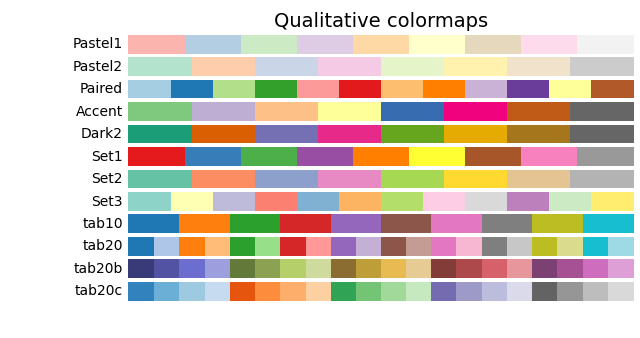

In [ ]:
## umap plot version 3. Manually update adata.uns['celltype_colors'] to choose any color you like (see available named colors below)
adata.uns['celltype_colors'] = ['yellow','cyan','darkorange','lime']

## [🔺] plot the final umap













**matplotlib named colors:**

https://matplotlib.org/stable/gallery/color/named_colors.html

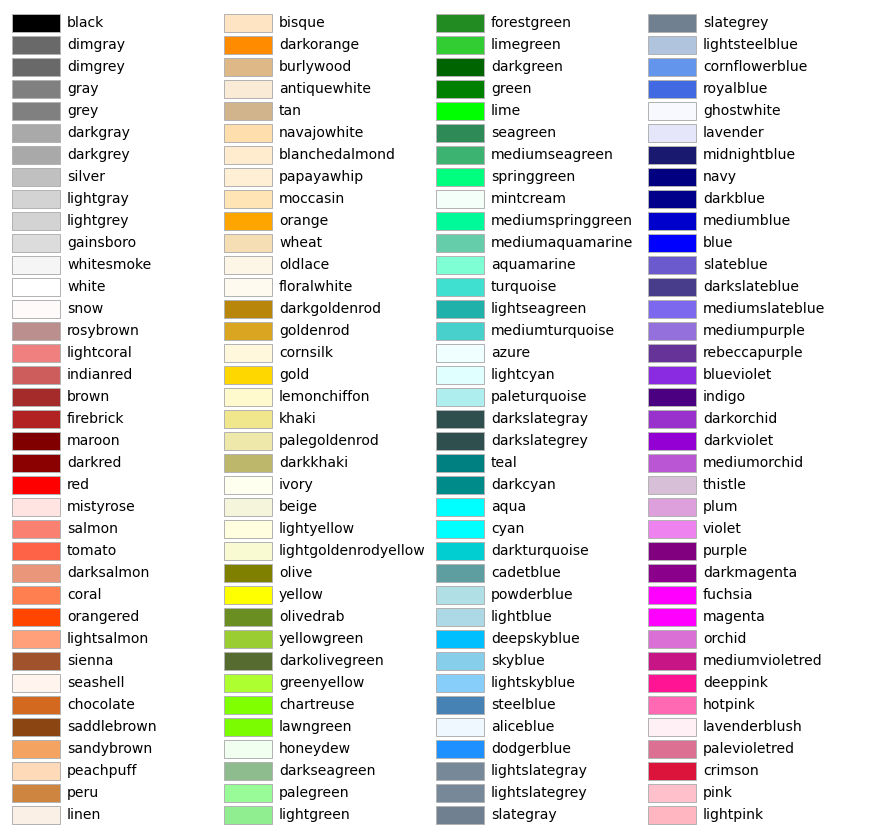

****

In [ ]:
# Further customizing umap: an artistic version
adata.uns['celltype_colors'] = ['dodgerblue','orange','firebrick','mediumseagreen']

sc.pl.umap(
      adata,
      color="celltype",
      add_outline=True,
      legend_loc="on data",
      legend_fontsize=25,
      legend_fontoutline=5,
      frameon=False,
      title="clustering of cells", # adding a plot title
      size=120,
  )

## 🔺 Differential Expression

In [ ]:
adata

In [ ]:
## [🔺]  use sc.tl.rank_genes_groups(...) to perform differential expression analysis across cell types














### 🔺 logFC with dot plot

In [ ]:
# visualize logfold change with sc.pl.rank_genes_groups_dotplot

# # command used in the pbmc tutorial
# sc.pl.rank_genes_groups_dotplot(pbmc,
#                                 n_genes=6,
#                                 values_to_plot='logfoldchanges',
#                                 min_logfoldchange=3,
#                                 vmax=5,
#                                 vmin=-5,
#                                 cmap='bwr',
#                                 dot_max=0.7
# )

# [🔺] adapt the above command for our dataset;
# try selecting genes with larger log fold change















### 🔺 DE matrix plot

In [ ]:
# [🔺] Lets also visualize the results with sc.pl.rank_genes_groups_matrixplot.
# Note: you can adapt the one we used in the pbmc tutorial. See also the reference guide
















In [ ]:
# (❓) Does your matrixplot show the same genes (x-axis) as your dotplot?

### 🔺 Explore other plots

In [ ]:
# Decide which other plots wou want to adapt from the pbmc tutorial and apply to this dataset.

In [ ]:
## [🔺] plot 1









# Why did you choose this plot?

In [ ]:
## [🔺] plot 2












# Why did you choose this plot?

## 🔺 Density plot

We haven't seen this plot in an example so you have to rely on the documentation (reference guide).

In [ ]:
## [🔺] compute umap density based on condition
# The `sc.tl.embedding_density` function calculates the density of cells within the UMAP space grouped by a given labels (condition in this case).
# See the reference guide for more info












In [ ]:
# Checking the column names in the 'obs' attribute of the AnnData object to see the added column.
adata.obs.columns

In [ ]:
## [🔺] Plot the UMAP density for each condition. The 'key' refers to the computed density values based on the 'condition' group.











In [ ]:
## [🔺] Now, compute the UMAP density based on another grouping, this time by 'patient_id' to see how cell density varies by patient.









In [ ]:
## [🔺] Plot UMAP density, but this time grouped by 'patient_id'.
## use the ncols parameter,and make the points larger because we have very few cells per patient (s parameter)










# Extra

## DE genes with pandas
For custom plotting and further analysis, we can extract the differential expression results from the AnnData object. The `sc.get.rank_genes_groups_df` function extracts DE genes computed by `scanpy` and stores it in a pandas DataFrame.


In [ ]:
# We can set a p-value cutoff and a minimum log fold-change to filter genes.
de_df = sc.get.rank_genes_groups_df(adata,group=None,pval_cutoff=1e-9,log2fc_min=4,)
de_df

In [ ]:
# Group the DE genes by their 'group' (which in this case is the cell type) and display the top 6 genes for each group.

de_df.groupby('group').head(6)

In [ ]:
# Now, select the top 20 DE genes for each group.
de_df_top20 =  de_df.groupby('group').head(20)
de_df_top20

### annotating genes on plots

In [ ]:
import seaborn as sns

In [ ]:
x_col = 'logfoldchanges'
y_col = 'scores'

# Plot the DE genes using Seaborn's `relplot`.
g = sns.relplot(data=de_df_top20,
                x=x_col,
                y=y_col,
                hue = 'group',
                kind='scatter',
                height=5,
                aspect=1,
                s=50)

sns.move_legend(g, 'upper right')

#################################################
# Annotate the top 3 genes per group on the plot.
# We loop through the top genes and add their names as text labels next to their points on the plot.
annotate_df = de_df_top20.groupby('group').head(3)
for i in range(annotate_df.shape[0]):
    g.ax.text(annotate_df[x_col].iloc[i],
              annotate_df[y_col].iloc[i],
              annotate_df['names'].iloc[i],
              horizontalalignment='left',   # Align text to the left of the point
              size='medium',                 # Set the size of the text
              color='black',                # Set the color of the text
              weight='regular',             # Set the weight of the text
              family='monospace')

In [ ]:
# Install adjustText, a package that helps adjust overlapping annotations in plots. This is used to prevent the gene labels from overlapping.

!pip install --quiet adjustText

In [ ]:
from adjustText import adjust_text

In [ ]:
x_col = 'logfoldchanges'
y_col = 'scores'


g = sns.relplot(data=de_df_top20,
                x=x_col,
                y=y_col,
                hue = 'group',
                kind='scatter',
                height=5,
                aspect=1,
                s=50)

sns.move_legend(g, 'upper right')

# Annotate the points with the gene names


annotate_df = de_df.groupby('group').head(3)
texts = [] #We store the text objects in a list called 'texts' for later adjustment.

for i in range(annotate_df.shape[0]):
    texts.append(
        g.ax.text(annotate_df[x_col].iloc[i],
              annotate_df[y_col].iloc[i],
              annotate_df['names'].iloc[i],
              horizontalalignment='left',   # Align text to the left of the point
              size='medium',                 # Set the size of the text
              color='black',                # Set the color of the text
              weight='regular',             # Set the weight of the text
              family='monospace')
    )

# Adjust the text annotations to avoid overlap, using `adjust_text`.
# We also add lines (`arrowprops`) to indicate the corresponding points for labels that are moved far from their data points.
_ = adjust_text(
    texts,
    expand=(1.5, 1.5),
    arrowprops=dict(color="gray", lw=1.5),
    ax=g.ax,
)

## Advanced: Volcano plot / DE between 2 clusters

This section performs differential expression (DE) analysis between two specific cell types or clusters.
We use the 'rank_genes_groups' function to rank genes that are differentially expressed between 'B cells' and 'Myeloid' cells.


In [ ]:
sc.tl.rank_genes_groups(adata,
                        groupby='celltype',
                        method='wilcoxon',
                        layer='log1p',
                        groups=['B cells'],  # The target group is 'B cells'.
                        reference='Myeloid', # The reference group is 'Myeloid' cells.
                        key_added='B_vs_Myeloid',  # Store the results under the key 'B_vs_Myeloid' for later retrieval.
                        rankby_abs=True,     # Rank genes by the absolute test statistic (score).
                        pts=True)            # Calculate the fraction of cells expressing each gene in the comparison.


In [ ]:
de_df = sc.get.rank_genes_groups_df(adata,group='B cells',pval_cutoff=1e-9,
                                    key='B_vs_Myeloid')### notice that we specify the key here to retrieve the relevant DE genes
de_df

In [ ]:
# Create a new column '-log_pval' (using the log fucntion from numpy) to store the negative log10-transformed adjusted p-values, which is useful for plotting (e.g., volcano plots).

import numpy as np
de_df['-log_pval'] = -np.log10(de_df['pvals_adj'])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

logfoldchanges = de_df['logfoldchanges']
pval = de_df['-log_pval']

# Create the scatter plot
plt.figure(figsize=(8, 6))
g = plt.scatter(logfoldchanges, pval, c=logfoldchanges, cmap='coolwarm_r', vmin=-4, vmax=4)

# Add labels and title
plt.xlabel('Log Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot')

# Add a colorbar
plt.colorbar(g, label='Log Fold Change')

# Set x-axis limits
plt.xlim([-20, 20])

# Set y-axis limits
plt.ylim([0, 220])

# Annotate top genes
# Top left: Large negative logfoldchanges and high p-value
top_left = de_df[(de_df['logfoldchanges'] < 0) & (de_df['logfoldchanges'].abs() > 5) & (de_df['-log_pval'] > 100)].sort_values(by='logfoldchanges')
# Top right: Large positive logfoldchanges and high p-value
top_right = de_df[(de_df['logfoldchanges'] > 0) & (de_df['logfoldchanges'].abs() > 5) & (de_df['-log_pval'] > 70)].sort_values(by='logfoldchanges')
# Combine top left and top right for annotation
annotate_df = pd.concat([top_left, top_right])

texts = []
for i in range(annotate_df.shape[0]):
  # Determine horizontal alignment based on the sign of logfoldchanges
    horizontal_align = 'left' if annotate_df['logfoldchanges'].iloc[i] > 0 else 'right'

    texts.append(
        plt.text(
            annotate_df['logfoldchanges'].iloc[i],    # X-coordinate
            annotate_df['-log_pval'].iloc[i],         # Y-coordinate
            annotate_df['names'].iloc[i],             # Gene names
            horizontalalignment=horizontal_align,
            size='medium',
            color='black',
            family='monospace'
        )
    )

# Adjust the annotations to avoid overlap
adjust_text(
    texts,
    expand=(1.2, 1.2),
    arrowprops=dict(color='gray', lw=1.5)
)

# Show the plot
plt.tight_layout()
plt.show()

## interactive plots

Here we use: https://github.com/holoviz/hvplot

See also: https://plotly.com/python/

In [ ]:
!pip install --quiet hvplot

In [ ]:
import hvplot.pandas

In [ ]:
de_df.hvplot.scatter(
    x="logfoldchanges", y="pvals_adj",  # Specify x and y axes
    flip_yaxis=True, logy=True,  # Flip y-axis and apply logarithmic scale
    hover_cols=["names"],
)

In [ ]:
### more parameters

de_df.hvplot.scatter(
    x="logfoldchanges", y="pvals_adj",  # Specify x and y axes
    flip_yaxis=True, logy=True,  # Flip y-axis and apply logarithmic scale
    hover_cols=["names"],  # Hover tool for gene names
    c="logfoldchanges",  # Color points based on log fold change values
    cmap="coolwarm_r",  # Use a diverging colormap to highlight high/low values
    size=30,  # Scale point size
    xlabel="Log Fold Change",  # Label x-axis
    ylabel="Adjusted P-values",  # Label y-axis
    marker="o",  # Use circle markers for better clarity
    frame_width=600, frame_height=400,  # Control plot size
    fontsize=15
).opts(
    colorbar=True, clim=(-5, 5)  # Set color limits explicitly in opts
)
